##### Домашнее задание

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
import pandas as pd
import scipy

In [2]:
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

In [3]:
random.seed(23)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = [] # новая бутстреп выборка
    
    for i in range(N): # цикл по кол-ву деревьев
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        b_indexes=[]
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1) # выбираем индекс нового объекта бутстреп выборки
            b_data[j] = data[sample_index] 
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [4]:

def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes) # перемешаем индексы
    subsample = sample_indexes[0:len_subsample].copy() # возьмем первые len_subsample
#     for _ in range(len_subsample):
#         subsample.append(sample_indexes.pop())
        
    #print(f'subsample = {subsample}')
    return subsample

In [5]:
# Реализуем класс узла

class Node:
    
    def __init__(self, data, index, t, true_branch, false_branch):
        self.data = data
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [7]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения
# !!! ИЗМЕНЕНИЯ !!! 
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample: # выбираем из подпространства признаков, для каждого нового разбиения будет новое подпространство 
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(data, index, t, true_branch, false_branch)

In [8]:
def random_forest(data, labels, n_trees):
    forest = [] # список деревьев
    bootstrap = get_bootstrap(data, labels, n_trees) # создаем n_trees бутстреп выборок
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels)) # добавляем по дереву в ансамбль
        
    return forest

In [9]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)  
    
    return classes

# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    #print(f'predictions_per_object = {predictions_per_object}')  
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    #print(f'voted_predictions = {voted_predictions}')    
    return voted_predictions

In [10]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 23)

In [11]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [12]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

In [35]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [36]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [37]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [38]:
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)

Text(0.5, 1.0, 'Test accuracy=86.67')

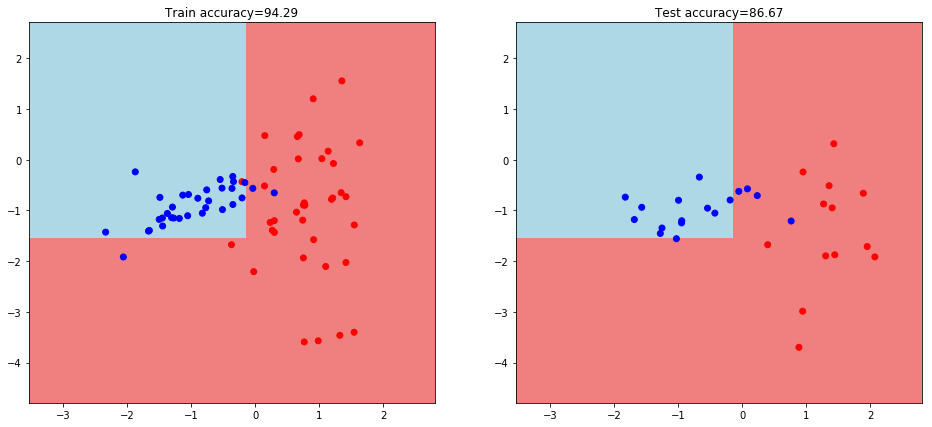

In [39]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_vote = np.array(tree_vote(my_forest_1,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_vote, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_vote, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [40]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

In [41]:
train_answers_3 = tree_vote(my_forest_3, train_data)
test_answers_3 = tree_vote(my_forest_3, test_data)
train_accuracy_3 = accuracy_metric(train_labels, train_answers_3)
test_accuracy_3 = accuracy_metric(test_labels, test_answers_3)

Text(0.5, 1.0, 'Test accuracy=90.00')

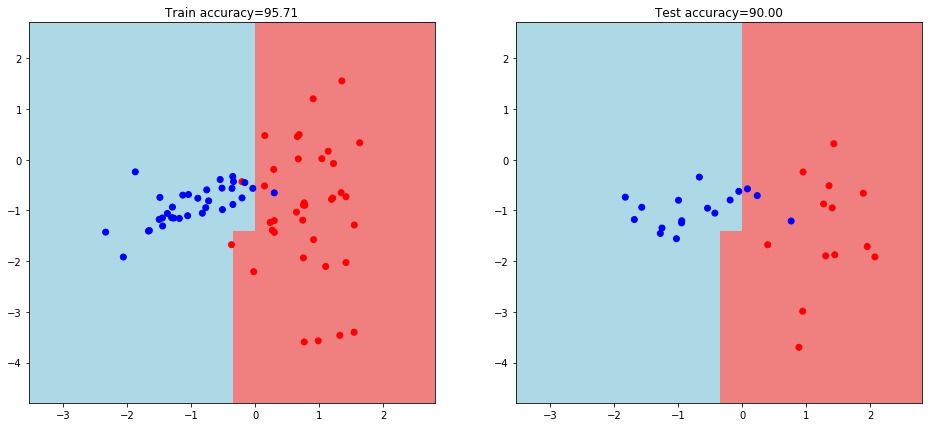

In [42]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_vote3 = np.array(tree_vote(my_forest_3,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_vote3, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_3:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_vote3, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_3:.2f}')

In [43]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

In [44]:
train_answers_10 = tree_vote(my_forest_10, train_data)
test_answers_10 = tree_vote(my_forest_10, test_data)
train_accuracy_10 = accuracy_metric(train_labels, train_answers_10)
test_accuracy_10 = accuracy_metric(test_labels, test_answers_10)

Text(0.5, 1.0, 'Test accuracy=90.00')

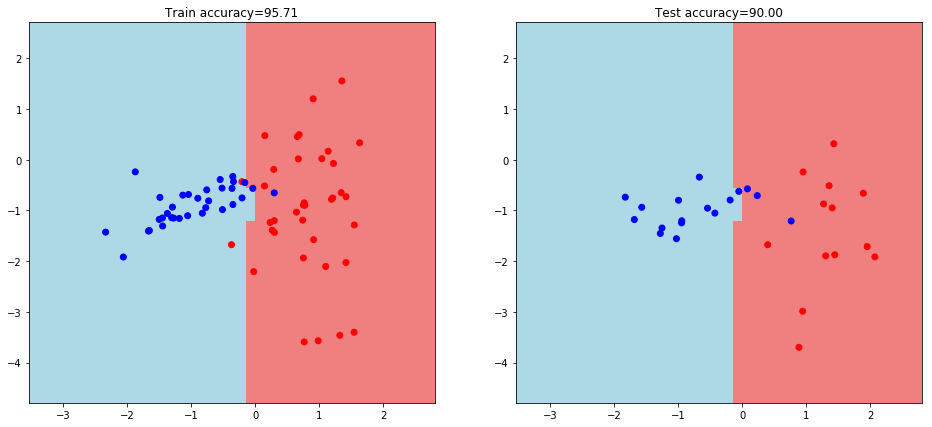

In [45]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_vote10 = np.array(tree_vote(my_forest_10,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_vote10, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_10:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_vote10, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_10:.2f}')

In [46]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

In [47]:
train_answers_50 = tree_vote(my_forest_50, train_data)
test_answers_50 = tree_vote(my_forest_50, test_data)
train_accuracy_50 = accuracy_metric(train_labels, train_answers_50)
test_accuracy_50 = accuracy_metric(test_labels, test_answers_50)

Text(0.5, 1.0, 'Test accuracy=90.00')

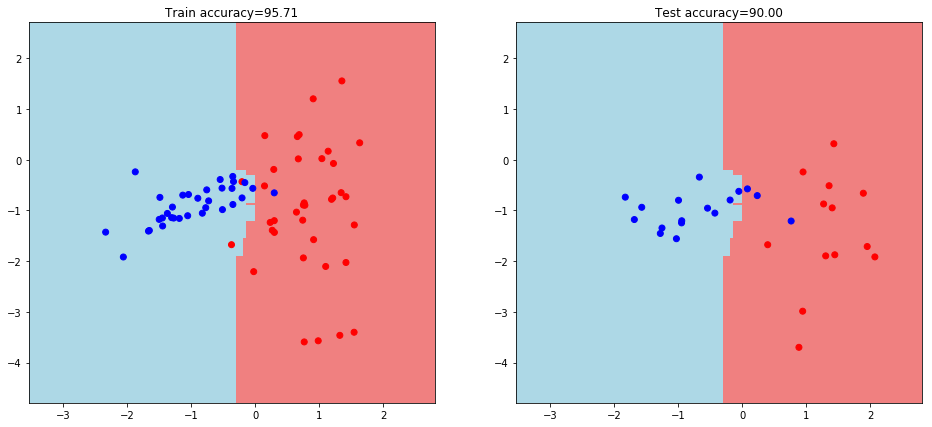

In [48]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_vote50 = np.array(tree_vote(my_forest_50,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_vote50, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_50:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_vote50, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_50:.2f}')

In [49]:
print(train_accuracy,test_accuracy)
print(train_accuracy_3,test_accuracy_3)
print(train_accuracy_10,test_accuracy_10)
print(train_accuracy_50,test_accuracy_50)

94.28571428571428 86.66666666666667
95.71428571428572 90.0
95.71428571428572 90.0
95.71428571428572 90.0


2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

В данном случае нельзя однозначно сказать о влиянии количества деревьев на переобучение леса. У леса из одного дерева плоскость достаточно простая, но наблюдается переобучение. У лесов из 10 и 50 деревьев гиперплоскости достаточно сложные, при этом не наблюдается прироста точности и сокращается разница между тренировочной и тестовой выборками. А у леса из 3 деревьев те же показатели точности, что и у более сложных деревьев, но плоскость более простая.

Получается, что оптимальное количество деревьев в данном случае - 3.

3*. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

Создадим лес, при создании которого будем использовать весь датасет целиком, без разбиения на train и test.

In [28]:
n_trees = 50
new_forest_50 = random_forest(classification_data, classification_labels, n_trees)

Напишем функцию tree_vote для отдельного объекта

In [29]:
# предсказание голосованием деревьев

def tree_vote_single(forest, x):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(classify_object(x, tree))
    
    # выберем в качестве итогового предсказания то,
    # за которое проголосовало большинство деревьев
    voted_prediction = max(set(predictions), key = predictions.count) 
 
    return voted_prediction

In [30]:
acc_metrics = []

for x in classification_data:
    x_forest=[]
    for tree in new_forest_50:
        if x not in tree.data:
            x_forest.append(tree)
            x_answer = tree_vote_single(x_forest, x) #Считаем итоговое предсказание по объекту среди деревьев, 
                                                     # которые на нем не обучались. 
            # считаем число правильных ответов по всем объектам
            if x_answer == classification_labels[np.argwhere(classification_data==x)[0][0]]:
                acc =1
            else:
                acc=0
            acc_metrics.append(acc)

# В качестве OOB error используем долю неправильных ответов
OOB_err = 1-sum(acc_metrics)/len(acc_metrics)

print(OOB_err,len(acc_metrics))

0.09863760217983653 1835


4*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

Формула _энтропии Шеннона_:

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

In [31]:
def calc_entropy(x, y, t):
    qty_all = len(y) # объектов всего
    qty_left = len(y[x < t]) # объектов в левой ветке
    qty_right = qty_all - qty_left  # объектов в правой ветке

    if qty_left == 0 or qty_right == 0:
        return np.inf

    qty0_left = ((y[x < t]) == 0).sum() 
    qty0_right = ((y[x >= t]) == 0).sum()
    
    if qty0_left in [0, qty_left] or qty0_right in [0, qty_right] :
        return np.inf      
        
    p0_left = qty0_left / qty_left # Доля объектов класса 0 слева
    p1_left = 1 - p0_left # Доля объектов класса 1 слева

    p0_right = qty0_right / qty_right  # Доля объектов класса 0 справа
    p1_right = 1 - p0_right # Доля объектов класса 1 справа

    left_coef = qty_left / qty_all

    # Энтропия Шеннона для левого листа
    h_left = -(p0_left * np.log2(p0_left) + p1_left * np.log2(p1_left))
    # Энтропия Шеннона для правого листа
    h_right = -(p0_right * np.log2(p0_right) + p1_right * np.log2(p1_right))

    res = left_coef * h_left + (1 - left_coef) * h_right
    return res

In [32]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 5, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)
y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

In [33]:
x = X[2,:]

In [34]:
calc_entropy(x, y, t=700)

0.965148445440323